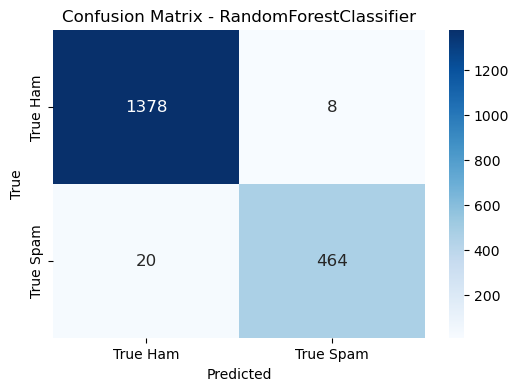

/Users/sam/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


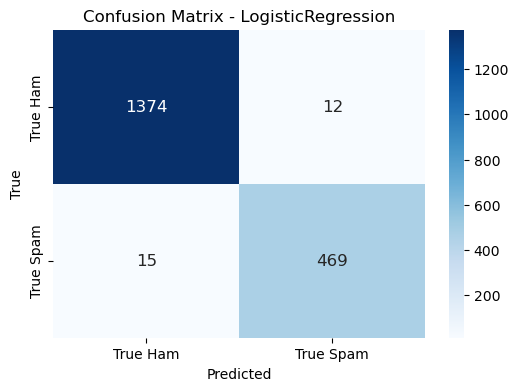

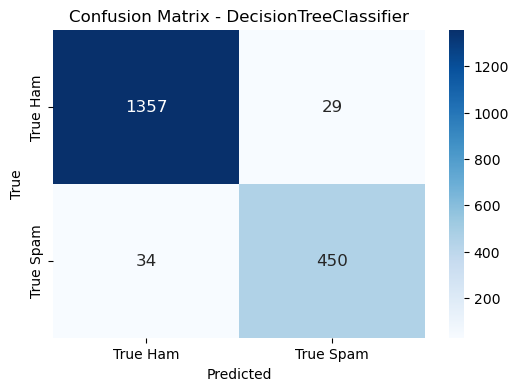

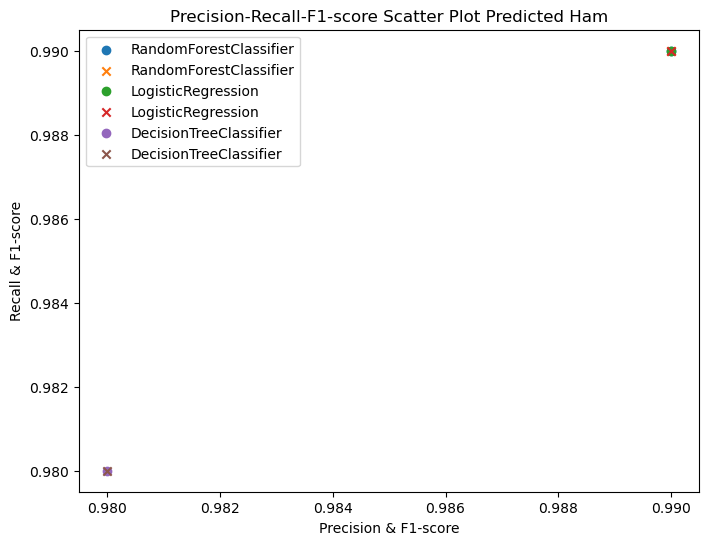

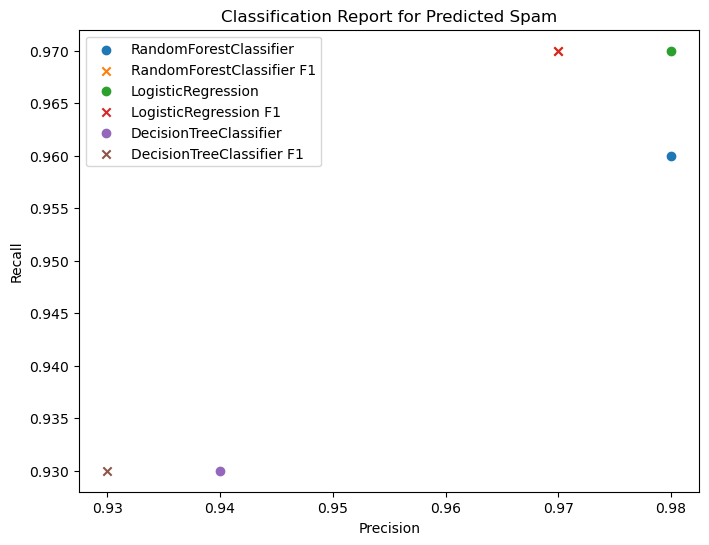

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import email
import os
import re
import nltk
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load ham and spam files
ham_fnames = [name for name in sorted(os.listdir("Resources/main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("Resources/main_spam"))]

# Function to parse email files
def parse_email(fname, spam=False):
    directory = "Resources/main_spam" if spam else "Resources/main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)

ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

# Function to convert HTML to plain text
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

# Transform the email to count the word usage in the message
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        self.stemmer = nltk.PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = re.sub(r'[^\w\s]', '', plain)
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

# Build a Numpy matrix with the vocabulary of words to consider and their usage counts
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
        return self
    
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
        return X_new

email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

X = np.array(ham_emails + spam_emails, dtype='object')
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

X_train_prepared = email_to_cvector.fit_transform(X_train)
X_test_prepared = email_to_cvector.transform(X_test)

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    model_prediction = model.predict(X_test)
    report = classification_report(y_test, model_prediction)
    matrix = confusion_matrix(y_test, model_prediction)
    return report, matrix

models = [
    RandomForestClassifier(random_state=3301),
    LogisticRegression(solver="lbfgs", random_state=3301, max_iter=1000),
    DecisionTreeClassifier(random_state=3301)
]

def extract_metrics(classification_report):
    lines = classification_report.split('\n')
    classes = []
    precision = []
    recall = []
    f1_score = []

    for line in lines[2:-3]:
        t = line.split()
        if len(t) > 4:
            classes.append(t[0])
            precision.append(float(t[1]))
            recall.append(float(t[2]))
            f1_score.append(float(t[3]))

    return classes, precision, recall, f1_score

precision_values_class_0 = []
recall_values_class_0 = []
precision_values_class_1 = []
recall_values_class_1 = []
f1_score_values_class_0 = []
f1_score_values_class_1 = []

for model in models:
    report, matrix = train_and_evaluate_model(model, X_train_prepared, X_test_prepared, y_train, y_test)
    
    classes, precision, recall, f1_score = extract_metrics(report)
    
    precision_values_class_0.append(precision[0])
    recall_values_class_0.append(recall[0])
    f1_score_values_class_0.append(f1_score[0])
    precision_values_class_1.append(precision[1])
    recall_values_class_1.append(recall[1])
    f1_score_values_class_1.append(f1_score[1])

    # Prepare the confusion matrix data as a DataFrame
    labels = ['True Ham', 'True Spam']
    cm_df = pd.DataFrame(matrix, index=labels, columns=labels)
    
    # Plotting the confusion matrix
    model_name = type(model).__name__
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='', annot_kws={"size": 12})
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


results_data = {
    'Model': [type(model).__name__ for model in models],
    'Precision_Class_0': precision_values_class_0,
    'Recall_Class_0': recall_values_class_0,
    'F1_Score_Class_0': f1_score_values_class_0,
    'Precision_Class_1': precision_values_class_1,
    'Recall_Class_1': recall_values_class_1,
    'F1_Score_Class_1': f1_score_values_class_1
}

results_df = pd.DataFrame(results_data)

plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    model_name = type(model).__name__
    plt.scatter(results_df['Precision_Class_0'][i], results_df['Recall_Class_0'][i], label=model_name, marker='o')
    plt.scatter(results_df['F1_Score_Class_0'][i], results_df['F1_Score_Class_0'][i], label=model_name, marker='x')

plt.xlabel('Precision & F1-score')
plt.ylabel('Recall & F1-score')
plt.title('Precision-Recall-F1-score Scatter Plot Predicted Ham')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    model_name = type(model).__name__
    plt.scatter(results_df['Precision_Class_1'][i], results_df['Recall_Class_1'][i], label=model_name, marker='o')
    plt.scatter(results_df['F1_Score_Class_1'][i], results_df['F1_Score_Class_1'][i], label=model_name + ' F1', marker='x')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Classification Report for Predicted Spam')
plt.legend()
plt.show()
